#### Ajustando dados de entrada

In [95]:
import pandas as pd
import calendar
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from pymc3.distributions.dist_math import bound
import scipy.stats as ss
import hydrobr

In [96]:
def le_dados_ana():
    lista_series_mensais=[]
    with open ('Clube_de_regatas.TXT','r') as file:
        for linha in file.readlines():
            if(linha.startswith("\n") or linha.startswith("/")):
                continue
            s=linha.replace(',','.').split(";")
            data_linha=datetime.strptime(s[2],'%d/%m/%Y')
            dias_no_mes=calendar.monthrange(data_linha.year,data_linha.month)
            rng=pd.date_range(data_linha,periods=dias_no_mes[1], freq='D')
            cons=[s[1] for i in range (dias_no_mes[1])]
            arrays=[rng,cons]
            tuples=list(zip(*arrays))
            index=pd.MultiIndex.from_tuples(tuples,names=['Data','Consistencia'])
            serie_linha=pd.Series(s[16:16+dias_no_mes[1]],index=index, name=s[0])
            lista_series_mensais.append(serie_linha)
    serie_completa=pd.concat(lista_series_mensais)
    serie_completa=pd.to_numeric(serie_completa, errors='coerce', downcast='float')
    serie_completa.sort_index(level=['Data','Consistencia'], inplace=True)
    definicao_de_duplicatas=serie_completa.reset_index(level=1, drop=True).index.duplicated(keep='last')
    dados_sem_duplicatas=serie_completa[~definicao_de_duplicatas]
    serie_com_index_unico=dados_sem_duplicatas.reset_index(level=1, drop=True)
    #serie_com_index_unico.to_json('test.json')
    return serie_com_index_unico

def calcula_ano_hidrologico(serie_com_index_unico):
    medias_mensais=serie_com_index_unico.groupby(pd.Grouper(freq='M')).mean()
    mes_menor_media=medias_mensais.groupby(pd.Grouper(freq='A')).idxmin()
    mes_menor_media=mes_menor_media.dt.month
    mes_comeca_ano_hidrologico=mes_menor_media.mode()
    return mes_comeca_ano_hidrologico

def calcula_maximas_anuais(serie_com_index_unico):
    serie_maximas_anuais=serie_com_index_unico.groupby(pd.Grouper(freq='AS-SEP')).max()
    return serie_maximas_anuais[:-1] #Desconsidera o último valor (ano incompleto)

In [97]:
serie_de_dados=le_dados_ana()
mes_comeca_ano_hidrologico=calcula_ano_hidrologico(serie_de_dados)

In [98]:
mes_comeca_ano_hidrologico

0    9
dtype: int64

In [99]:
serie_maximas_anuais=calcula_maximas_anuais(serie_de_dados)
serie_maximas_anuais

Data
1940-09-01    372.480988
1941-09-01    559.979004
1942-09-01    591.476013
1943-09-01    394.835999
1944-09-01    568.922974
                 ...    
2009-09-01    786.273010
2010-09-01    658.395020
2011-09-01    406.454010
2012-09-01    577.911987
2013-09-01    248.539993
Freq: AS-SEP, Name: 61834000, Length: 74, dtype: float32

In [100]:
serie_maximas_anuais[4:-1].mean()

649.7725219726562

Text(0.5, 0, 'Time (year)')

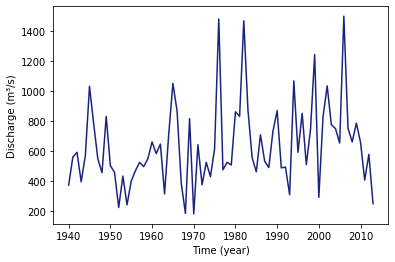

In [101]:

plt.plot(serie_maximas_anuais.index.map(lambda x: x.year), serie_maximas_anuais, color='#1A237E')
plt.ylabel('Discharge (m³/s)')
plt.xlabel('Time (year)')

#### Posterior Predictive Check GEV0 (estacionário)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [scale, loc, c]
Sampling chain 1, 3 divergences: 100%|███████████████████████████████████████████| 4000/4000 [00:03<00:00, 1127.23it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F246CD8C8>,
      dtype=object)

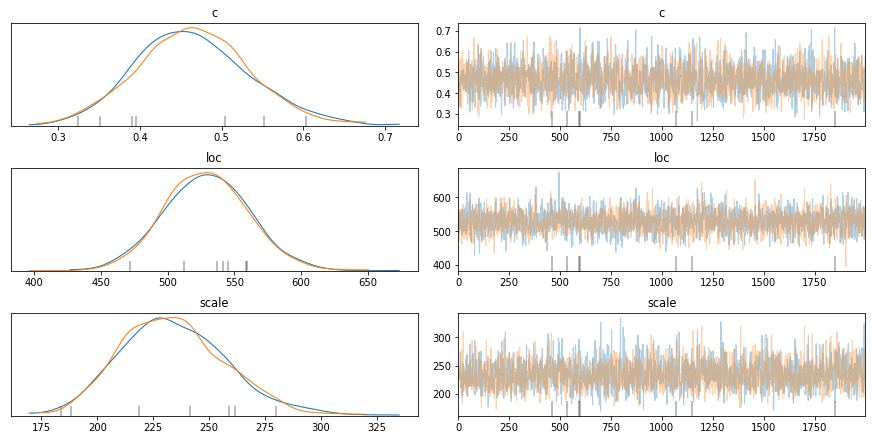

In [102]:
annual_max = serie_maximas_anuais[4:-1]

with pm.Model() as Model_gev_0:
    # Priors for unknown model parameters
    c = pm.Beta('c', alpha=6, beta=9) #c=x-0.5: transformation in gev_logp is required due to Beta domain between 0 and 1
    loc = pm.Uniform('loc', lower=-10000, upper=10000)
    scale = pm.Uniform('scale', lower=0, upper=5000)

    # Likelihood (sampling distribution) of observations | Since GEV is not implemented in pymc a custom log likelihood function was created
    def gev_logp(value):
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    
    def gev0_rng(point=None, size=None):
        # draw a numerical value for the parameters
        loc_, scale_, c_ = draw_values([loc, scale, c], point=point)
        size = 1 if size is None else size
        return generate_samples(ss.genextreme.rvs, c=-(c_-0.5), loc=loc_, scale=scale_, size=size, broadcast_shape=(size,))
    
    gev = pm.DensityDist('gev', gev_logp, observed=annual_max, random=gev0_rng)
    trace_gev0 = pm.sample(2000, chains=2, cores=1, tune=2000, progressbar=True)
az.plot_trace(trace_gev0)

In [103]:
az.summary(trace_gev0)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
c,0.465,0.069,0.324,0.586,0.001,0.001,2387.0,2377.0,2388.0,2488.0,1.0
loc,528.762,31.132,468.305,585.653,0.630,0.448,2442.0,2420.0,2459.0,2516.0,1.0
scale,233.886,23.529,191.433,277.774,0.488,0.346,2323.0,2318.0,2329.0,2383.0,1.0


In [104]:
with Model_gev_0:
    ppc_gev0 = pm.sample_posterior_predictive(
        trace_gev0, var_names=["c", "loc", "scale"])

100%|███████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 16129.39it/s]


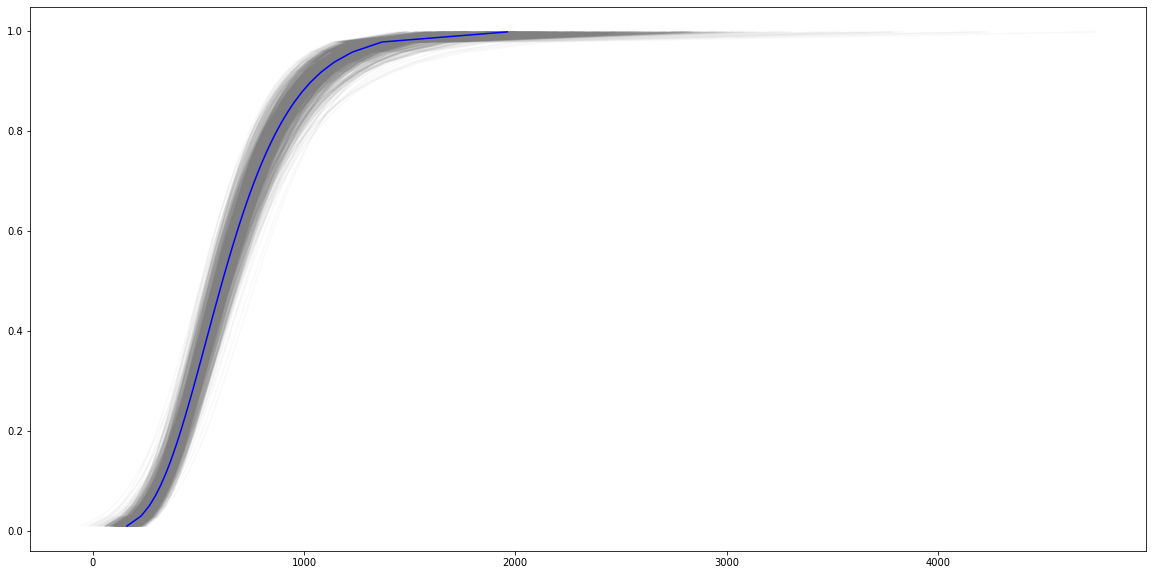

In [105]:
percentiles = np.linspace(0.01, 0.999, 50)
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(1000):
    ppc_estimates=[]
    for p in percentiles:
        ppc_estimates.append(ss.genextreme.ppf(p, -(ppc_gev0["c"][i]-0.5), ppc_gev0["loc"][i], ppc_gev0["scale"][i]))
    ax.plot(ppc_estimates, percentiles, color='gray', alpha=0.05)
    
mean = []
for p in percentiles:
    mean.append(ss.genextreme.ppf(p, -(ppc_gev0["c"].mean()-0.5), ppc_gev0["loc"].mean(), ppc_gev0["scale"].mean()))

ax.plot(mean, percentiles, color='blue')  

In [106]:
percentiles = np.linspace(0.01, 0.99, 50)

mean = []
for p in percentiles:
    mean.append(ss.genextreme.ppf(p, -(ppc_gev0["c"].mean()-0.5), ppc_gev0["loc"].mean(), ppc_gev0["scale"].mean()))

fig = go.Figure(data=go.Scatter(x=mean,
                                y=percentiles,
                               mode='lines'))

for i in range(10):
    spaghetti = []
    for p in percentiles:
        spaghetti.append(ss.genextreme.ppf(p, -(ppc_gev0["c"][i]-0.2), ppc_gev0["loc"][i], ppc_gev0["scale"][i]))
    fig.add_trace(go.Scatter(x=spaghetti, y=percentiles,
                    mode='lines', name='markers'))

fig.show()

#### Posterior Predictive Check GEV1 (t covariante)

In [107]:
ppc_gev0["c"].min()

0.26433204702200175

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:04<00:00, 575.48it/s]
The acceptance probability does not match the target. It is 0.8930906136226374, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F25740A08>,
      dtype=object)

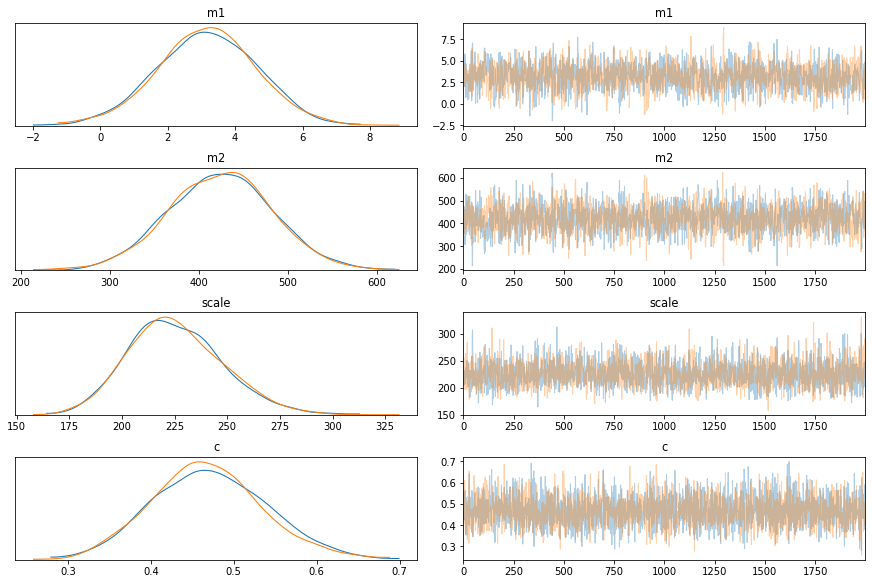

In [108]:
with pm.Model() as Model_gev_1:
    t=range(len(annual_max))
    m1 = pm.Uniform('m1', lower=-100, upper=100)
    m2 = pm.Uniform('m2', lower=-1000, upper=1000)
    scale = pm.Uniform('scale', lower=0, upper=10000)
    c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

    # Likelihood (sampling distribution)
    def gev_logp(value, t):
        loc=m1*t+m2
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed={'value': annual_max, 't': t})
    trace_gev1 = pm.sample(2000, chains=2, cores=1, progressbar=True)
az.plot_trace(trace_gev1)

In [109]:
az.summary(trace_gev1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m1,3.145,1.456,0.277,5.777,0.035,0.025,1713.0,1713.0,1712.0,2043.0,1.0
m2,423.528,57.821,305.680,522.935,1.378,0.991,1761.0,1704.0,1761.0,1817.0,1.0
scale,225.407,22.285,185.733,267.886,0.471,0.334,2243.0,2227.0,2234.0,2456.0,1.0
c,0.469,0.068,0.342,0.597,0.001,0.001,2906.0,2850.0,2935.0,2504.0,1.0


In [110]:
with Model_gev_1:
    ppc_gev1 = pm.sample_posterior_predictive(
        trace_gev1, var_names=["c", "m1", "m2", "scale"])

100%|███████████████████████████████████████████████████████████████████████████| 4000/4000 [00:00<00:00, 21284.70it/s]


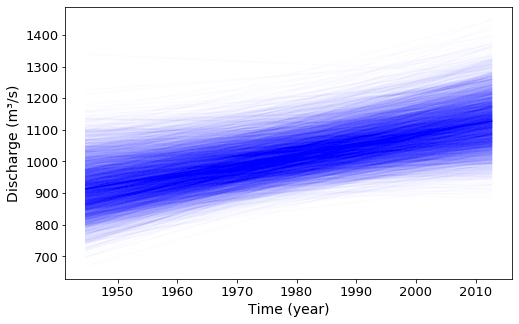

In [216]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.rcParams.update({'font.size': 13})
ax.tick_params(axis='both',labelsize=13)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)
ax.set_xlabel('Time (year)', fontsize=14)

years=range(len(serie_maximas_anuais[4:-1]))
years_mask=serie_maximas_anuais[4:-1].index

#Plot GEV1 Spaghetti
for i in range(len(ppc_gev1["c"])):
    spaghetti_gev1=[]
    for t in years:
        spaghetti_gev1.append(ss.genextreme.ppf(0.9, -(ppc_gev1["c"][i]-0.5), ppc_gev1["m1"][i]*t+ppc_gev1["m2"][i], ppc_gev1["scale"][i]))
    ax.plot(years_mask, spaghetti_gev1, color='blue', alpha=0.01)

mean = []
for t in years:
    mean.append(ss.genextreme.ppf(0.9, -(ppc_gev1["c"].mean()-0.5), ppc_gev1["m1"].mean()*t+ppc_gev1["m2"].mean(), ppc_gev1["scale"].mean()))

ax.plot(years_mask, mean, color='blue')  

In [214]:
years_mask

DatetimeIndex(['1944-09-01', '1945-09-01', '1946-09-01', '1947-09-01',
               '1948-09-01', '1949-09-01', '1950-09-01', '1951-09-01',
               '1952-09-01', '1953-09-01', '1954-09-01', '1955-09-01',
               '1956-09-01', '1957-09-01', '1958-09-01', '1959-09-01',
               '1960-09-01', '1961-09-01', '1962-09-01', '1963-09-01',
               '1964-09-01', '1965-09-01', '1966-09-01', '1967-09-01',
               '1968-09-01', '1969-09-01', '1970-09-01', '1971-09-01',
               '1972-09-01', '1973-09-01', '1974-09-01', '1975-09-01',
               '1976-09-01', '1977-09-01', '1978-09-01', '1979-09-01',
               '1980-09-01', '1981-09-01', '1982-09-01', '1983-09-01',
               '1984-09-01', '1985-09-01', '1986-09-01', '1987-09-01',
               '1988-09-01', '1989-09-01', '1990-09-01', '1991-09-01',
               '1992-09-01', '1993-09-01', '1994-09-01', '1995-09-01'],
              dtype='datetime64[ns]', name='Data', freq='AS-SEP')

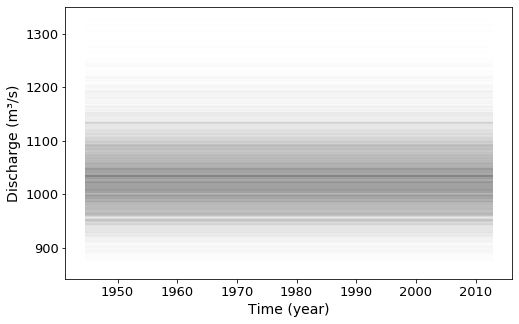

In [208]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.rcParams.update({'font.size': 13})
ax.tick_params(axis='both',labelsize=13)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)
ax.set_xlabel('Time (year)', fontsize=14)

#Plot GEV0 spaghetti
for i in range(len(ppc_gev0['c'])):
    spaghetti_gev0=[]
    spaghetti_gev0.append(ss.genextreme.ppf(0.9, -(ppc_gev0["c"][i]-0.5), ppc_gev0["loc"][i], ppc_gev0["scale"][i]))
    ax.plot(years_mask, spaghetti_gev0*len(years_mask), color='gray', alpha=0.01)
    
mean_gev0 = []

# Plot GEV0 mean
mean_gev0.append(ss.genextreme.ppf(0.9, -(ppc_gev0["c"].mean()-0.5), ppc_gev0["loc"].mean(), ppc_gev0["scale"].mean()))
ax.plot(years_mask, mean_gev0*len(years_mask), color='gray')

#### Checando falhas na série de precipitação

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.00s/it]


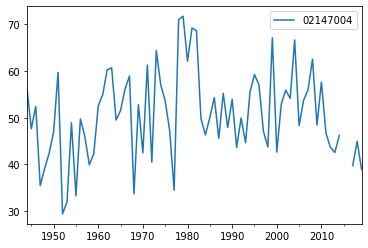

In [113]:
prec = hydrobr.get_data.ANA.prec_data(['02147004'])
prec_99 = prec.groupby(pd.Grouper(freq='AS-SEP')).quantile(0.99)
prec_99.plot()

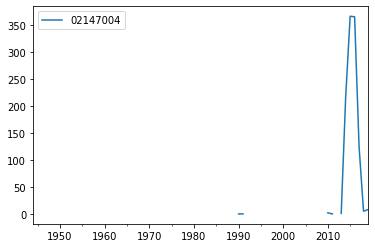

In [114]:
from plotly.offline import iplot
gantt_fig = hydrobr.Plot.gantt(prec) #Get Gantt Fig from hydrobr
# print(gantt_fig)

#Updating the layout
gantt_fig.update_layout(
    autosize=False,
    width=1000,
    height=1200,
    xaxis_title = 'Year',
    yaxis_title = 'Station Code',
    font=dict(family="Courier New, monospace", size=13))

# #To plot and save the gantt plot as html
def conta_numero_de_falhas(serie_com_index_unico):
    serie_com_index_unico.sort_index(inplace=True)
    nfalhas=serie_com_index_unico.isnull().sum()
    resumo_falhas=serie_com_index_unico.isnull().groupby(pd.Grouper(freq = 'AS-SEP')).sum().to_period()
    resumo_falhas=resumo_falhas[resumo_falhas>0]
    return resumo_falhas, nfalhas

resumo_falhas, nfalhas = conta_numero_de_falhas(prec)
resumo_falhas.plot()

#To plot and save the gantt plot as html
iplot(gantt_fig)

#### Posterior Predictive Check GEV1 P99

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 6 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:10<00:00, 231.35it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F37847948>,
      dtype=object)

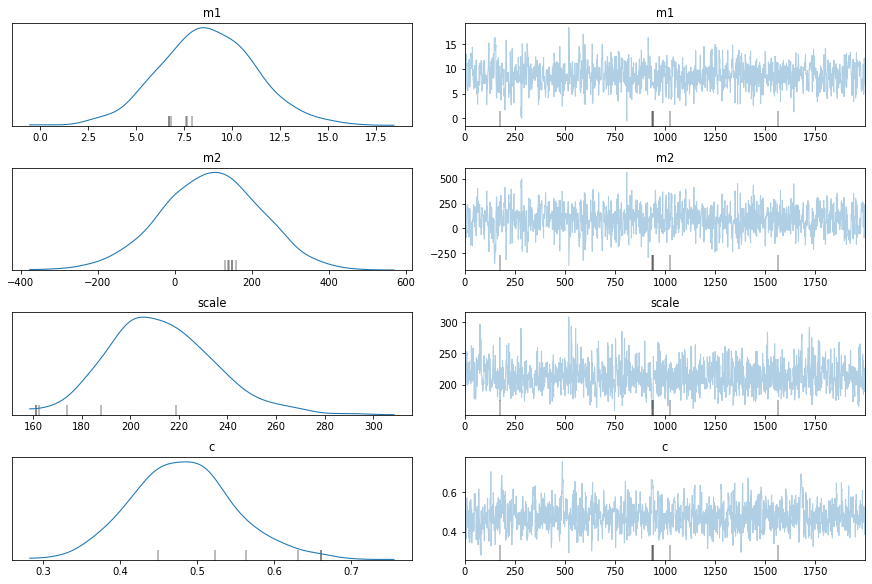

In [115]:
prec99_data=serie_maximas_anuais[4:-1].to_list()
covariant=prec_99[:-7]['02147004'].to_list()
with pm.Model() as Model_gev1P99:
    m1 = pm.Uniform('m1', lower=-100, upper=100)
    m2 = pm.Uniform('m2', lower=-10000, upper=10000)
    scale = pm.Uniform('scale', lower=0, upper=10000)
    c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

    # Likelihood (sampling distribution)
    def gev_logp(value, t):
        loc=m1*t+m2
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed={'value': prec99_data, 't': covariant})
    trace_gev1P99 = pm.sample(2000, chains=1, cores=1, progressbar=True)
az.plot_trace(trace_gev1P99)

In [116]:
az.summary(trace_gev1P99)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m1,8.692,2.465,4.478,13.813,0.089,0.065,760.0,709.0,760.0,758.0,NaN
m2,90.611,128.319,-168.730,313.385,4.683,3.313,751.0,751.0,757.0,812.0,NaN
scale,212.732,21.778,172.950,254.351,0.723,0.512,906.0,906.0,862.0,718.0,NaN
c,0.481,0.067,0.360,0.611,0.003,0.002,699.0,645.0,738.0,446.0,NaN


In [117]:
with Model_gev1P99:
    ppc_gev1P99 = pm.sample_posterior_predictive(
        trace_gev1P99, var_names=["c", "m1", "m2", "scale"])

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 21562.66it/s]


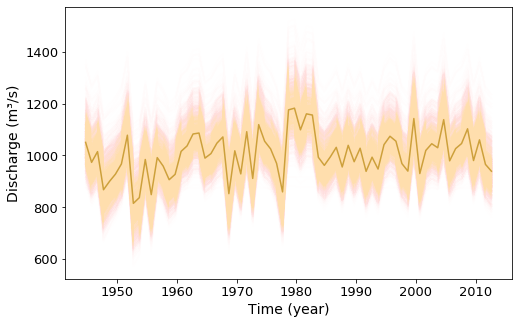

In [207]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.rcParams.update({'font.size': 13})
ax.tick_params(axis='both',labelsize=13)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)
ax.set_xlabel('Time (year)', fontsize=14)

years=range(len(covariant))
years_mask=prec_99[:-7]['02147004'].index
# p=prec_99[:-7]['02147004'].values

for i in range(len(ppc_gev1P99['c'])):
    spaghetti_gev1P99=[]
    for p in prec_99[:-7]['02147004'].values:
        spaghetti_gev1P99.append(ss.genextreme.ppf(0.9, -(ppc_gev1P99["c"][i]-0.5), ppc_gev1P99["m1"][i]*p+ppc_gev1P99["m2"][i], ppc_gev1P99["scale"][i]))
    ax.plot(years_mask, spaghetti_gev1P99, color='navajowhite', alpha=0.01) # Essa cor é bege!
mean = []
for p in prec_99[:-7]['02147004'].values:
    mean.append(ss.genextreme.ppf(0.9, -(ppc_gev1P99["c"].mean()-0.5), ppc_gev1P99["m1"].mean()*p+ppc_gev1P99["m2"].mean(), ppc_gev1P99["scale"].mean()))
ax.plot(years_mask, mean, color='darkgoldenrod', alpha=0.7)
# ax.plot(years_mask, mean, color='blue')  

In [213]:
len(years_mask)

52

#### Posterior Predictive Check GEV1 PAcum

In [119]:
prec_acum=prec.groupby(pd.Grouper(freq='AS-SEP')).sum()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:12<00:00, 207.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F3CFE0C88>,
      dtype=object)

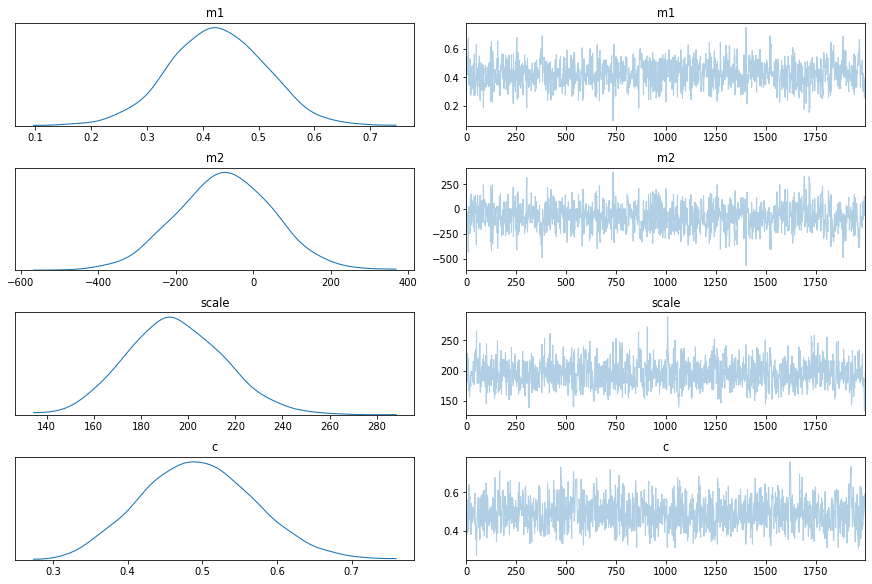

In [120]:
prec_acum_data=serie_maximas_anuais[4:-1].to_list()
covariant_Pacum=prec_acum[:-7]['02147004'].to_list()
with pm.Model() as Model_gev1PAcum:
    m1 = pm.Uniform('m1', lower=-100, upper=100)
    m2 = pm.Uniform('m2', lower=-10000, upper=10000)
    scale = pm.Uniform('scale', lower=0, upper=10000)
    c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

    # Likelihood (sampling distribution)
    def gev_logp(value, t):
        loc=m1*t+m2
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed={'value': prec_acum_data, 't': covariant_Pacum})
    trace_gev1PAcum = pm.sample(2000, chains=1, cores=1, progressbar=True)
az.plot_trace(trace_gev1PAcum)

In [121]:
az.summary(trace_gev1PAcum)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m1,0.425,0.084,0.259,0.573,0.003,0.002,585.0,580.0,585.0,804.0,NaN
m2,-74.974,123.725,-305.889,152.765,5.098,3.606,589.0,589.0,588.0,879.0,NaN
scale,194.522,20.657,158.661,235.432,0.738,0.522,783.0,783.0,779.0,717.0,NaN
c,0.494,0.075,0.352,0.628,0.003,0.002,740.0,696.0,764.0,754.0,NaN


In [122]:
with Model_gev1PAcum:
    ppc_gevPAcum = pm.sample_posterior_predictive(
        trace_gev1PAcum, var_names=["c", "m1", "m2", "scale"])

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 22473.06it/s]


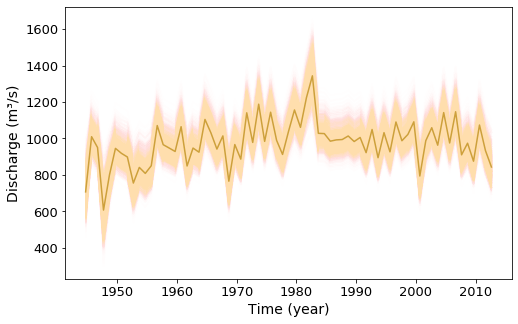

In [206]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.rcParams.update({'font.size': 13})
ax.tick_params(axis='both',labelsize=13)
ax.set_ylabel('Discharge (m³/s)', fontsize=14)
ax.set_xlabel('Time (year)', fontsize=14)

years=range(len(covariant_Pacum))
years_mask=prec_acum[:-7]['02147004'].index

for i in range(len(ppc_gevPAcum['c'])):
# for i in range(10):
    spaghetti_gev1PAcum=[]
    for p in prec_acum[:-7]['02147004'].values:
        spaghetti_gev1PAcum.append(ss.genextreme.ppf(0.9, -(ppc_gevPAcum["c"][i]-0.5), ppc_gevPAcum["m1"][i]*p+ppc_gevPAcum["m2"][i], ppc_gevPAcum["scale"][i]))
    ax.plot(years_mask, spaghetti_gev1PAcum, color='navajowhite', alpha=0.01) # Essa cor é bege!
mean = []
for p in prec_acum[:-7]['02147004'].values:
    mean.append(ss.genextreme.ppf(0.9, -(ppc_gevPAcum["c"].mean()-0.5), ppc_gevPAcum["m1"].mean()*p+ppc_gevPAcum["m2"].mean(), ppc_gevPAcum["scale"].mean()))
ax.plot(years_mask, mean, color='darkgoldenrod', alpha=0.7)

### PSIS-LOO model comparison

In [124]:
df_comp_loo = az.compare({"GEV0": trace_gev0, "GEV1": trace_gev1, "GEV1 P99": trace_gev1P99, "GEV1 PAcum": trace_gev1PAcum}, ic="loo")
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
GEV1 PAcum,0,947.037,3.42603,0,0.913017,13.3785,0,False,deviance
GEV1 P99,1,957.23,3.34246,10.1924,0.0664954,13.3069,6.2008,False,deviance
GEV1,2,964.629,3.30065,17.5915,0.0179025,13.6535,8.08587,False,deviance
GEV0,3,967.845,2.48385,20.8075,0.00258493,12.9524,7.74272,False,deviance


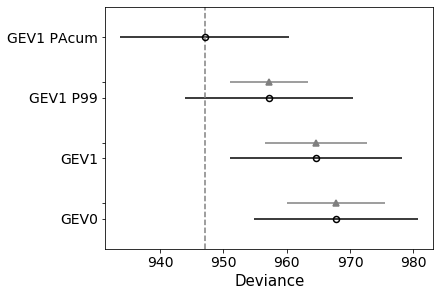

In [125]:
az.plot_compare(df_comp_loo, insample_dev=False);

### Evolution Return Period over time

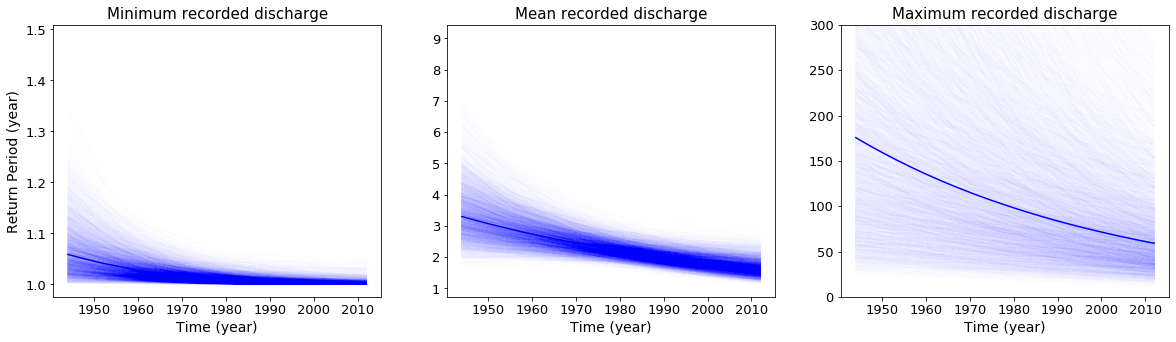

In [201]:
ax=[]
fig, ax = plt.subplots(1,3, figsize=(20, 5))
x = serie_maximas_anuais[4:-1].index.year
years = range(len(x))
ppc_gev1
# Plot GEV1 Spaghetti
for i in range(len(ppc_gev1["c"])):
# for i in range(10):
    spaghetti_min_gev1=[]
    spaghetti_mean_gev1=[]
    spaghetti_max_gev1=[]
    for t in years:
        spaghetti_min_gev1.append(1/(1-ss.genextreme.cdf(serie_maximas_anuais[4:-1].min(), -(ppc_gev1["c"][i]-0.5), ppc_gev1["m1"][i]*t+ppc_gev1["m2"][i], ppc_gev1["scale"][i])))
        spaghetti_mean_gev1.append(1/(1-ss.genextreme.cdf(serie_maximas_anuais[4:-1].mean(), -(ppc_gev1["c"][i]-0.5), ppc_gev1["m1"][i]*t+ppc_gev1["m2"][i], ppc_gev1["scale"][i])))
        spaghetti_max_gev1.append(1/(1-ss.genextreme.cdf(serie_maximas_anuais[4:-1].max(), -(ppc_gev1["c"][i]-0.5), ppc_gev1["m1"][i]*t+ppc_gev1["m2"][i], ppc_gev1["scale"][i])))
    ax[0].plot(x, spaghetti_min_gev1, color='blue', alpha=0.005)
    ax[1].plot(x, spaghetti_mean_gev1, color='blue', alpha=0.005)
    ax[2].plot(x, spaghetti_max_gev1, color='blue', alpha=0.005)

ax[0].set_title("Minimum recorded discharge", fontsize=15)
ax[1].set_title("Mean recorded discharge", fontsize=15)
ax[2].set_title("Maximum recorded discharge", fontsize=15)
plt.rcParams.update({'font.size': 13})
ax[2].set_ylim([0,300])
ax[0].tick_params(axis='both',labelsize=13)
ax[0].set_ylabel('Return Period (year)', fontsize=14)
for i in range(3):
    ax[i].set_xlabel('Time (year)', fontsize=14)

spaghetti_max_gev1

min = []
for t in years:
    min.append(1/(1-ss.genextreme.cdf(serie_maximas_anuais[4:-1].min(), -(ppc_gev1["c"].mean()-0.5), ppc_gev1["m1"].mean()*t+ppc_gev1["m2"].mean(), ppc_gev1["scale"].mean())))
ax[0].plot(x, min, color='blue')

mean = []
for t in years:
    mean.append(1/(1-ss.genextreme.cdf(serie_maximas_anuais[4:-1].mean(), -(ppc_gev1["c"].mean()-0.5), ppc_gev1["m1"].mean()*t+ppc_gev1["m2"].mean(), ppc_gev1["scale"].mean())))
ax[1].plot(x, mean, color='blue')

max = []
for t in years:
    max.append(1/(1-ss.genextreme.cdf(serie_maximas_anuais[4:-1].max(), -(ppc_gev1["c"].mean()-0.5), ppc_gev1["m1"].mean()*t+ppc_gev1["m2"].mean(), ppc_gev1["scale"].mean())))
ax[2].plot(x, max, color='blue')

In [193]:
serie_maximas_anuais[4:-1].max()

1499.530029296875

## Dividindo série em calibração e validação

In [126]:
#Input calibração

discharge_calibrate = serie_maximas_anuais[4:-18]
prec99_calibrate = prec_99[:-24]
precAcum_calibrate = prec_acum[:-24]
t_calibrate = t=list(range(len(discharge_calibrate)))

Len dados de precipitação = 69: Ou seja, 52 anos para calibração e 17 anos para validação

Calibração: 1944 - 1995

Validação: 1996 - 2013

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [scale, loc, c]
Sampling chain 1, 8 divergences: 100%|████████████████████████████████████████████| 4000/4000 [00:04<00:00, 976.17it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value wo

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F3DEC3A88>,
      dtype=object)

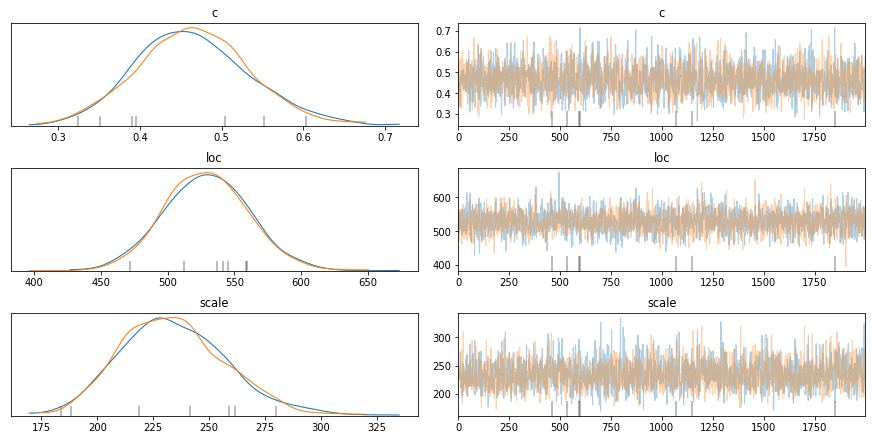

In [127]:
annual_max = discharge_calibrate

with pm.Model() as Model_gev_0_calibrate:
    # Priors for unknown model parameters
    c = pm.Beta('c', alpha=6, beta=9) #c=x-0.5: transformation in gev_logp is required due to Beta domain between 0 and 1
    loc = pm.Uniform('loc', lower=-10000, upper=10000)
    scale = pm.Uniform('scale', lower=0, upper=5000)

    # Likelihood (sampling distribution) of observations | Since GEV is not implemented in pymc a custom log likelihood function was created
    def gev_logp(value):
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed=annual_max)
    trace_gev0_calibrate = pm.sample(2000, chains=2, cores=1, tune=2000, progressbar=True)
az.plot_trace(trace_gev0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:05<00:00, 487.42it/s]
The acceptance probability does not match the target. It is 0.8884124896553051, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argumen

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F407810C8>,
      dtype=object)

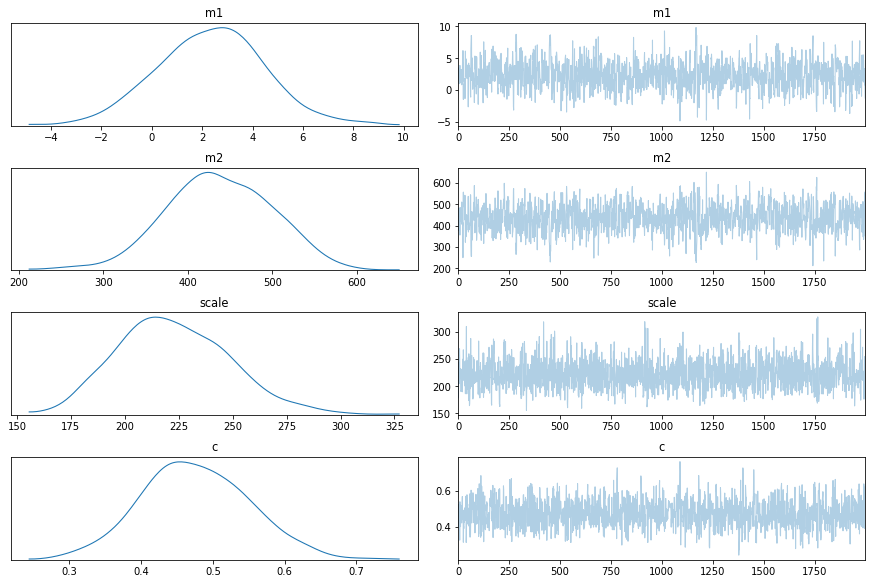

In [128]:
annual_max = discharge_calibrate
t = t_calibrate

with pm.Model() as Model_gev_1_calibrate:
    t=range(len(annual_max))
    m1 = pm.Uniform('m1', lower=-100, upper=100)
    m2 = pm.Uniform('m2', lower=-1000, upper=1000)
    scale = pm.Uniform('scale', lower=0, upper=10000)
    c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

    # Likelihood (sampling distribution)
    def gev_logp(value, t):
        loc=m1*t+m2
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed={'value': annual_max, 't': t})
    trace_gev1_calibrate = pm.sample(2000, chains=1, cores=1, progressbar=True)
az.plot_trace(trace_gev1_calibrate)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences: 100%|█████████████████████████████████████████████| 2500/2500 [01:21<00:00, 30.57it/s]
The acceptance probability does not match the target. It is 0.900184393806333, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F45FD1EC8>,
      dtype=object)

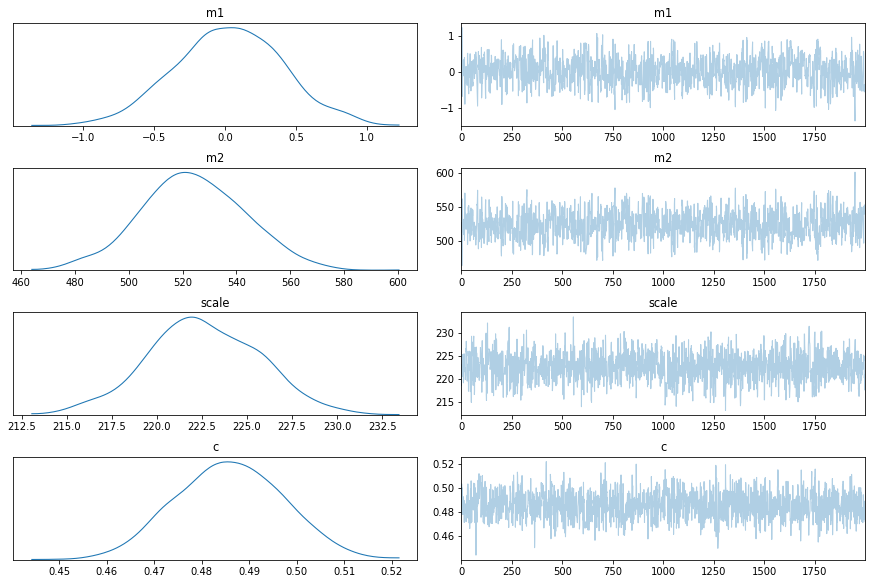

In [129]:
annual_max = discharge_calibrate
covariant=prec99_calibrate

with pm.Model() as Model_gev1P99_calibrate:
    m1 = pm.Uniform('m1', lower=-100, upper=100)
    m2 = pm.Uniform('m2', lower=-10000, upper=10000)
    scale = pm.Uniform('scale', lower=0, upper=10000)
    c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

    # Likelihood (sampling distribution)
    def gev_logp(value, t):
        loc=m1*t+m2
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed={'value': prec99_data, 't': covariant})
    trace_gev1P99_calibrate = pm.sample(2000, chains=1, cores=1, progressbar=True)
az.plot_trace(trace_gev1P99_calibrate)

In [130]:
prec_acum_data=discharge_calibrate
covariant_Pacum=precAcum_calibrate

with pm.Model() as Model_gev1PAcum_calibrate:
    m1 = pm.Uniform('m1', lower=-100, upper=100)
    m2 = pm.Uniform('m2', lower=-10000, upper=10000)
    scale = pm.Uniform('scale', lower=0, upper=10000)
    c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

    # Likelihood (sampling distribution)
    def gev_logp(value, t):
        loc=m1*t+m2
        scaled = (value - loc) / scale
        logp = -(tt.log(scale)
                 + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                 + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
        bound1 = loc - scale/(c-0.5)
        bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
        return bound(logp, bounds, c != 0)
    gev = pm.DensityDist('gev', gev_logp, observed={'value': prec_acum_data, 't': covariant_Pacum})
    trace_gev1PAcum_calibrate = pm.sample(2000, chains=1, cores=1, progressbar=True)
az.plot_trace(trace_gev1PAcum_calibrate)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences:   0%|                                                        | 0/2500 [00:00<?, ?it/s]


SamplingError: Bad initial energy

In [ ]:
discharge_validate = serie_maximas_anuais[-18:].values
prec99_validate = prec_99['02147004'][52:-6].values
precAcum_validate = prec_acum[52:-6].values
t_validate = t=list(range(len(discharge_calibrate)))

In [ ]:
az.summary(trace_gev0)['mean']

In [ ]:
c = az.summary(trace_gev0_calibrate)['mean'][0]-0.5
loc = az.summary(trace_gev0_calibrate)['mean'][1]
scale = az.summary(trace_gev0_calibrate)['mean'][2]

def check_likelihood_gev0(data, c, loc, scale):
    likelihood_set=[]
    for d in data:
        likelihood_set.append(ss.genextreme.cdf(d, -c, loc, scale))
    return np.prod(likelihood_set)
              
likelihood_validate_gev0 = check_likelihood_gev0(discharge_validate, c, loc, scale)    

In [ ]:
m1 = az.summary(trace_gev1_calibrate)['mean'][0]
m2 = az.summary(trace_gev1_calibrate)['mean'][1]
scale = az.summary(trace_gev1_calibrate)['mean'][2]
c = az.summary(trace_gev1_calibrate)['mean'][3]-0.5

def check_likelihood_gev1(data, covariant, c, m1, m2, scale):
    likelihood_set=[]
    for i in range(len(data)):
        likelihood_set.append(ss.genextreme.cdf(data[i], -c, m1*covariant[i]+m2, scale))
    return np.prod(likelihood_set)

likelihood_validate_gev1 = check_likelihood_gev1(discharge_validate, t_validate, c, m1, m2, scale)

In [ ]:
def check_likelihood_gev1(data, covariant, c, m1, m2, scale):
    likelihood_set=[]
    for i in range(len(data)):
        likelihood_set.append(ss.genextreme.cdf(data[i], -c, m1*covariant[i]+m2, scale))
    return np.prod(likelihood_set)

m1 = az.summary(trace_gev1P99_calibrate)['mean'][0]
m2 = az.summary(trace_gev1P99_calibrate)['mean'][1]
scale = az.summary(trace_gev1P99_calibrate)['mean'][2]
c = az.summary(trace_gev1P99_calibrate)['mean'][3]-0.5

likelihood_gev1P99 = check_likelihood_gev1(discharge_validate, prec99_validate, c, m1, m2, scale)

In [ ]:
m1 = az.summary(trace_gev1PAcum_calibrate)['mean'][0]
m2 = az.summary(trace_gev1PAcum_calibrate)['mean'][1]
scale = az.summary(trace_gev1PAcum_calibrate)['mean'][2]
c = az.summary(trace_gev1PAcum_calibrate)['mean'][3]-0.5

def check_likelihood_gev1(data, covariant, c, m1, m2, scale):
    likelihood_set=[]
    for i in range(len(data)):
        likelihood_set.append(ss.genextreme.cdf(data[i], -c, m1*covariant[i]+m2, scale))
    return np.prod(likelihood_set)

likelihood_gev1PAcum = check_likelihood_gev1(discharge_validate, precAcum_validate, c, m1, m2, scale)

In [ ]:
(likelihood_validate_gev0, likelihood_validate_gev1, likelihood_gev1P99, likelihood_gev1PAcum)

### Bayesian Model Averaging

In [73]:
df_comp_loo_time_only = az.compare({"GEV0": trace_gev0, "GEV1": trace_gev1}, ic="loo")
traces_time_only = [trace_gev0, trace_gev1]
models_time_only = [Model_gev_0, Model_gev_1]

RANDOM_SEED = 8927
# traces = [ppc_gev0, ppc_gev1, ppc_gev1P99, ppc_gevPAcum]
# models = [Model_gev_0, Model_gev_1, Model_gev1P99, Model_gev1PAcum]
ppc_w = pm.sample_posterior_predictive_w(
    traces_time_only,
    1000,
    models_time_only,
    weights=df_comp_loo_time_only.weight.sort_index(ascending=True),
    progressbar=True,
    random_seed=np.random.seed(RANDOM_SEED)
)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


ValueError: Distribution was not passed any random method Define a custom random method and pass it as kwarg random

In [71]:
RANDOM_SEED = 8927
print(np.random.seed(RANDOM_SEED))

None


(array([0.0465405 , 0.16641755, 0.38501688, 0.31168033, 0.26796046,
        0.13398023, 0.05923337, 0.0155135 , 0.01974446, 0.00423095]),
 array([ 997.93523876,  998.64429859,  999.35335841, 1000.06241824,
        1000.77147807, 1001.48053789, 1002.18959772, 1002.89865755,
        1003.60771738, 1004.3167772 , 1005.02583703]),
 <a list of 1 Patch objects>)

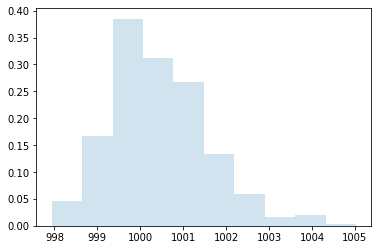

In [85]:
fig, ax = plt.subplots()
ax.hist(ss.genextreme.rvs(c=0.1, loc=1000, size=1000), density=True, histtype='stepfilled', alpha=0.2)

In [93]:
a = np.random.seed(1)
print(a)

None
